In [1]:
#Latest 02/14/2022

In [2]:
gpu_flag = True # Used when running in local PC with GPU

google_colab_flag = False # Only when used in Google Colab

lambda_flag = False  #Used when running on Lambada Labs

is_local = True


In [3]:
if(google_colab_flag or lambda_flag):
    !pip install -U --pre efficientnet
    !pip install Augmentor

In [4]:
import tensorflow as tf



if(gpu_flag ):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only allocate 3GB of memory on the first GPU
        try:
            tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4500)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
            print(e)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
1 Physical GPUs, 1 Logical GPUs


## Import Library

In [5]:
import glob
import os
import random
import shutil
import time
from datetime import datetime

import pandas as pd


from tensorflow import keras



import pathlib

import numpy as np
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers


from sklearn.model_selection import StratifiedKFold


from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2

import Augmentor

In [7]:
from keras.utils.layer_utils import count_params



## One time operation for file transfer

## Set Operation Path (Local vs Cloud)

In [8]:

# For training in Google Colab
if(google_colab_flag):
    from google.colab import drive
    drive.mount('/content/drive')
    !ls
    import sys
    root_path = '/content/drive/My Drive/Colab Notebooks/' # This is the path to where in google drive the code is stored!
    sys.path.append(root_path)

# For local training
else:
    #root_path = os.getcwd()
    root_path = ''

## Set All File Path

In [9]:
#Path of the Original Images
if(google_colab_flag):
    path = root_path + 'Original'
else:
    path = root_path + './Original'

if(google_colab_flag):
    folder_data= root_path + 'Images'
else:
    folder_data= root_path + './Images'


#MODEL_FILENAME=root_path+"model_cv.h5"
#Convert to directory type
data_dir = pathlib.Path(folder_data)
print(data_dir)

#Verify the image count to make sure we have all the pictures
image_count = len(list(data_dir.glob('**/*/*.jpeg')))
print('Total Images: ' , image_count)
print('===============================')

# Path of the train folder
TRAIN_PATH = folder_data + '/Train'
print(TRAIN_PATH)

# Path of the validation folder
VAL_PATH = folder_data + '/Validation'
print(VAL_PATH)


# Path of the test folder
TEST_PATH = folder_data + '/Test'
print(TEST_PATH)

# Defining the directory for train, validation and test images
data_dir_train = pathlib.Path(folder_data + '/Train')
data_dir_val = pathlib.Path(folder_data + '/Validation')
data_dir_test = pathlib.Path(folder_data + '/Test')

#Image count in each of the folders
image_count_train = len(list(data_dir_train.glob('*/*.jpeg')))
print(image_count_train)
image_count_val = len(list(data_dir_val.glob('*/*.jpeg')))
print(image_count_val)
image_count_test = len(list(data_dir_test.glob('*/*.jpeg')))
print(image_count_test)

TRAIN_PATH_NEW = TRAIN_PATH + "/"


Images
Total Images:  1426
./Images/Train
./Images/Validation
./Images/Test
1162
125
139


### Set Parameters

In [10]:
#List for source file names
sourceFiles=[]

#Set the class lebels from original Dataset
classLabels= os.listdir(path)
num_classes = len(classLabels)

#For X & Y lists
X=[]
Y=[]

#Set Image size
batch_size = 64
img_height = 224
img_width = 224

#Show full text in Dataframe
#pd.set_option("display.max_colwidth", None)

In [11]:
train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen  = ImageDataGenerator(rescale = 1/255)

In [12]:
def resetParameters(bath,height,width):
    batch_size = bath
    img_height = height
    img_width = width


## File move methods

In [13]:
def moveFiles(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def moveAllFiles(source, dest, splitRate):
    for label in classLabels:
        moveFiles(folder_data+'/'+source+'/'+label+'/', 
                               folder_data+'/'+dest+'/'+label+'/', 
                               splitRate)

## Functions for Accuracy Check

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
def check_Accuracy(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

## Move all files to Train

In [15]:
moveAllFiles('Test', 'Train', 1.0)
moveAllFiles('Validation', 'Train', 1.0)

if os.path.exists(folder_data + '/Temp'):
    # delete train folder
    shutil.rmtree(TRAIN_PATH)
    # Copy back from temp folder
    source = folder_data + '/Temp'
    dest =  TRAIN_PATH
    shutil.copytree(source,dest )
    shutil.rmtree(source)


### Saperate data for testing

In [16]:
#transferAllClassBetweenFolders('train', 'test', 0.10)


In [17]:
def setClassNameLabels(folderName):
    sourceFiles=os.listdir(folder_data+'/Train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
            if(folderName==classLabels[i]):
                Y.append(i)

## Set file names for splitting

In [18]:
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
    setClassNameLabels(classLabels[i])

In [19]:
X=np.asarray(X)
Y=np.asarray(Y)

print(X)
print(Y)

['BLB1_02ca69d3-b850-4091-af2a-bb72a07b7cd1.jpeg'
 'BLB1_04fd04a1-3992-4e35-bcc9-713dc3ee0afd.jpeg'
 'BLB1_09001d16-4e5f-4baf-880f-1511064e1015.jpeg' ...
 'Stemborer2_f2961d08-7e3b-4d05-8a4d-95c4cf5cf339.jpeg'
 'Stemborer2_f7cad769-ece7-4676-86bc-084188a9fd7c.jpeg'
 'Stemborer2_fd90a80c-e21b-445b-b760-c382b4b5d62e.jpeg']
[0 0 0 ... 8 8 8]


# Check later on if this is required

In [20]:
trn_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical'
)

Found 1426 images belonging to 9 classes.


In [21]:
trn_dataset.samples 

1426

In [22]:
vld_dataset = validation_datagen.flow_from_directory(
    data_dir_val,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical'
)

Found 0 images belonging to 9 classes.


In [23]:
tst_dataset = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical'
)

Found 0 images belonging to 9 classes.


In [24]:
classes_nm =  list(trn_dataset.class_indices.keys())
print(classes_nm)

['BLB', 'BPH', 'Brown_Spot', 'False_Smut', 'Healthy_Plant', 'Hispa', 'Neck_Blast', 'Sheath_Blight_Rot', 'Stemborer']


In [25]:
CLASS_NAMES =  list(trn_dataset.class_indices.keys())
print(CLASS_NAMES)

['BLB', 'BPH', 'Brown_Spot', 'False_Smut', 'Healthy_Plant', 'Hispa', 'Neck_Blast', 'Sheath_Blight_Rot', 'Stemborer']


In [26]:
print(list(trn_dataset.class_indices.values()))

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [27]:
num_classes = len(trn_dataset.class_indices)
print(num_classes)

9


In [28]:
# Creating an empty Dataframe to store results
df_report = pd.DataFrame(columns=[
    'Model_Name',
    'Test_No',
    'Batch_Size', 
    'Epoch', 
    'Count',
    'Train_Average',
    'Val_Average',
    'Val_Maximum',
    'Val_Minimum',
    'Val_StandardDev',
    'Is_TL',
    'Is_SVM',
    'Is_TL_Tune',
    'Train_History',
    'Val_History',
    'Train_Summary', 
    'Val_Summary', 
    'Total_params',
    'Trainable_params',
    'Non_trainable_params',
    'Total_Records',
    'Execution_Time',
    'Precision', 
    'f1Score',
    'No_Fold',
    'Date_Time'
    ], dtype=object)
                                  

## Image Agumentation funstion

In [29]:
def count_images(imgPath):
    data_dir = pathlib.Path(imgPath)
    #print(data_dir)

    #Verify the image count to make sure we have all the pictures
    image_count = len(list(data_dir.glob('**/*.jpeg')))
    #print('Total Images: ' , image_count)
    #print('===============================')
    
    return image_count

In [30]:
def img_augmentor(path_to_training_dataset_new,CLASS_NAMES, factor):
    
    for i in CLASS_NAMES:
        temp_path = path_to_training_dataset_new + i
        req_img = count_images(temp_path) * factor
        print('\n',req_img)
        p = Augmentor.Pipeline(temp_path)
        p.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
        p.flip_left_right(probability=0.5)
        p.flip_top_bottom(probability=0.5)
        p.rotate90(probability=0.5)
        p.rotate270(probability=0.5)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.skew(0.4, 0.5) 
        p.random_contrast(probability=0.5,min_factor = 0.2, max_factor = 0.8)
        p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
        p.flip_left_right(probability=0.5)
        
        p.sample(req_img) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

In [31]:
def move_new_images(path_to_training_dataset_new , CLASS_NAMES):
    
    for i in CLASS_NAMES:
        original_path = path_to_training_dataset_new + i
        image_count_original = count_images(original_path)
        print('Before move - ', image_count_original)
        temp_path = original_path +'/output'
        image_count_temp = count_images(temp_path)

        file_names = os.listdir(temp_path)
        #print(files)

        #shutil.copytree(, , dirs_exist_ok=True)
        source_dir = temp_path
        target_dir = original_path

        for file_name in file_names:
            shutil.move(os.path.join(source_dir, file_name), target_dir)

        shutil.rmtree(source_dir)

        #shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
        image_count_original = count_images(original_path)
        print('After move - ', image_count_original)


In [32]:
def delete_aug_data(path_to_training_dataset_new , CLASS_NAMES):
    
    for i in CLASS_NAMES:
        original_path = path_to_training_dataset_new + i

        temp_path = original_path +'/output'

        source_dir = temp_path
        
        if os.path.exists(source_dir):
            shutil.rmtree(source_dir)


# ======> End of Checking

# Main Model Bulding Functions

## Stratified K-Fold Cross validation

In [33]:

def runStratifiedKFold(model,conv_base, batchsize,epochsNo,nosplit, df_report , 
                       createModel, modelId ,Is_TL,Is_SVM, Is_TL_Tune , Test_No,
                       TRAIN_PATH , TRAIN_PATH_NEW, CLASS_NAMES , image_factor ):
    
    
    start_time = time.time()

    print("Started at =", datetime.now().strftime("%H:%M:%S"))
    MODEL_NM = model.layers[1].name.upper()
    print('Started Model -> ',MODEL_NM)
    
    
    print('#################################################################')
    print('\n Test run = ',Test_No)

    batch_size = batchsize
    
    if (Is_TL_Tune):
        Is_TL = True
        
        
    #Delete the temp folder and if it exists already
    if os.path.exists(folder_data + '/Temp'):
        shutil.rmtree(folder_data + '/Temp')
        
    #Delete the output folder and if it exists already
    delete_aug_data(TRAIN_PATH_NEW , CLASS_NAMES)
    

    trainAcclist = []
    valAcclist = []
    valPreclist =[]
    valFScorelist =[]

    no_split = nosplit

    skf = StratifiedKFold(n_splits = no_split,random_state=42, shuffle=True)
    skf.get_n_splits(X, Y)
    foldNum=0
    for train_index, val_index in skf.split(X, Y):
        epochs = epochsNo
        #First cut all images from validation to train (if any exists)
        moveAllFiles('Validation', 'Train', 1.0)
        foldNum+=1
        print("\n Results for fold",foldNum)
        
        #Create Checking Folders 
        CHECK_PATH = folder_data + '/Checking'
        MODEL_PATH = CHECK_PATH + '/' + MODEL_NM 
        MODEL_FOLDER_PATH = MODEL_PATH + '/'  + str(foldNum)
        print('\n Folders Created ----->')
        for dirname in classLabels:
            folder_path_test = MODEL_FOLDER_PATH + '/'+ dirname
            #print(folder_path_test)
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            if not os.path.exists(MODEL_FOLDER_PATH):
                os.mkdir(MODEL_FOLDER_PATH)


            if os.path.exists(folder_path_test):
                shutil.rmtree(folder_path_test)
            if not os.path.exists(folder_path_test):
                os.mkdir(folder_path_test)
        #End of createing test folders
            
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        # Move validation images of this fold from train folder to the validation folder
        for eachIndex in range(len(X_val)):
            classLabel=''
            for i in range(len(classLabels)):
                if(Y_val[eachIndex]==i):
                    classLabel=classLabels[i]
            #Then, copy the validation images to the validation folder
            shutil.move(folder_data+'/Train/'+classLabel+'/'+X_val[eachIndex], 
                        folder_data+'/Validation/'+classLabel+'/'+X_val[eachIndex])
            
            #print('Validation Data copied')

            
            #Create a copy of the 
            #shutil.copy2(folder_data+'/Validation/'+classLabel+'/'+X_val[eachIndex], 
            #         MODEL_FOLDER_PATH+'/'+classLabel+'/'+X_val[eachIndex])
            #print(MODEL_FOLDER_PATH+'/'+classLabel+'/')
            #print('Test Data copied')
            
            
        
        #Create a backup of the Train folder
        source = TRAIN_PATH
        dest = folder_data + '/Temp' 
        shutil.copytree(source,dest )
        
        if (image_factor>1):
            #Generate extra images
            img_augmentor(TRAIN_PATH_NEW , CLASS_NAMES, image_factor)

            #Move the new imgaes to training folders
            move_new_images(TRAIN_PATH_NEW , CLASS_NAMES)
            

        #Start ImageClassification Model
        train_generator = train_datagen.flow_from_directory(
            data_dir_train,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training')
        
        print('Train data length ====== ', train_generator.samples)

        validation_generator = validation_datagen.flow_from_directory(
            data_dir_val,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode=None,  # only data, no labels
            shuffle=False)   
        
        print('Test data length ====== ', validation_generator.samples)

        #Create model at each iteration
        if (createModel):
            model , conv_base = getModel(modelId,False , Is_TL, Is_SVM, Is_TL_Tune)
        print('Before Fine Tuning---->')
        print(model.summary())
        
        # fit model
        history=model.fit(train_generator, 
                            epochs=epochs)
        
        if (Is_TL_Tune):            #Tune the model
            
            conv_base.trainable = True
           
         
            
            optimiser = optimizers.Adam(learning_rate=1e-5)
            model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

            print('After Fine Tuning---->')
            print(model.summary())
            
            #epochs = epochsNo//2
            history=model.fit(train_generator, 
                                epochs=epochs)

            
        
        
        
        #showAccLoss(history,epochsNo)
        
        print("***Performance on Training data***") 
        trainAcc = history.history['categorical_accuracy']
        trainAcclist.append(trainAcc[-1])
        print("Accuracy  : {}".format(trainAcc[-1]))
        print("======================================*")

        predictions = model.predict(validation_generator, verbose=1)
        yPredictions = np.argmax(predictions, axis=1)
        true_classes = validation_generator.classes
        # evaluate validation performance
        print("***Performance on Validation data***")    
        valAcc, valPrec, valFScore = check_Accuracy(true_classes, yPredictions)

        valAcclist.append(valAcc)
        valPreclist.append(valPrec)
        valFScorelist.append(valFScore)
        
        
        
        #Restore the training folder ---- 
        
        # delete train folder
        shutil.rmtree(TRAIN_PATH)
        # Copy back from temp folder
        source = folder_data + '/Temp'
        dest =  TRAIN_PATH
        shutil.copytree(source,dest )
        shutil.rmtree(source)
        
        
    
        
    
    trainAccSummary = getSummary(trainAcclist)
    print('Train Summary=====>')
    print(trainAccSummary)
    
    valAccSummary = getSummary(valAcclist)
    print('Validation Summary=====>')
    print(valAccSummary)
    
    print('End Model -> ',model.layers[1].name.upper())
    print("Started at =", datetime.now().strftime("%H:%M:%S"))
    execMinutes = (time.time() - start_time)/60
    print("--- %s minutes ---" % (execMinutes))
    
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    
    total_images = train_generator.samples + validation_generator.samples
    
    df_report = df_report.append(
            {

                'Model_Name': model.layers[1].name.upper() , 
                'Test_No': Test_No ,
                'Batch_Size': batchsize , 
                'Epoch': epochsNo, 
                'No_Fold': nosplit, 
                'Count': valAccSummary[0],
                'Train_Summary': trainAccSummary, 
                'Val_Summary': valAccSummary, 
                'Train_History':trainAcclist,
                'Val_History':valAcclist,
                'Train_Average' : trainAccSummary[1],
                'Val_Average': valAccSummary[1],
                'Val_Maximum': valAccSummary[7],
                'Val_Minimum': valAccSummary[3],
                'Val_StandardDev': valAccSummary[2],
                'Total_params': (trainable_count+non_trainable_count),
                'Trainable_params': trainable_count,
                'Non_trainable_params': non_trainable_count,
                'Total_Records': total_images,
                'Execution_Time': execMinutes,
                'Is_TL' : Is_TL ,
                'Is_SVM' : Is_SVM,
                'Is_TL_Tune' : Is_TL_Tune,
                'Date_Time' : datetime.now()

            }
        , ignore_index=True)
    
    
    return df_report

    

In [34]:
def getSummary(Acclist):
    
    print(Acclist)
    s = pd.Series(Acclist)
    return s.describe()

    


In [35]:
from matplotlib import pyplot as plt

def showAccLoss(history,num_epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## InceptionV3

In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

def createModel_InceptionV3(Is_TL ):
  
    if (Is_TL):
        conv_base=InceptionV3(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
    else:
          conv_base=InceptionV3(weights=None,include_top=False,input_shape=(img_height,img_width,3))
      
    print('InceptionV3')
      #print(conv_base.summary())

    return conv_base

# Model Execution

In [37]:

def getModel(modelId , printSummary , Is_TL, Is_SVM, Is_TL_Tune):
    
    if model_dict[modelId] == 'VGG16':
        conv_base =  createModel_VGG16(Is_TL)
        
    elif model_dict[modelId] == 'VGG19':
        conv_base =  createModel_VGG19(Is_TL)
        
    elif model_dict[modelId] == 'ResNet50':
        conv_base =  createModel_ResNet50(Is_TL)
        
    elif model_dict[modelId] == 'ResNet50V2':
        conv_base =  createModel_ResNet50V2(Is_TL)
        
    elif model_dict[modelId] == 'ResNet152V2':
        conv_base =  createModel_ResNet152V2(Is_TL)
        
    elif model_dict[modelId] == 'EfficientNetB1':
        conv_base =  createModel_EfficientNetB1()

        
    elif model_dict[modelId] == 'EfficientNetB7':
        conv_base =  createModel_EfficientNetB7(Is_TL)

        
    elif model_dict[modelId] == 'MobileNetV2':
        conv_base =  createModel_MobileNetV2(Is_TL)

        
    elif model_dict[modelId] == 'InceptionV3':
        conv_base =  createModel_InceptionV3(Is_TL)

        
    elif model_dict[modelId] == 'DenseNet201':
        conv_base =  createModel_DenseNet201(Is_TL)

        
    elif model_dict[modelId] == 'EfficientNetB6':
        conv_base =  createModel_EfficientNetB6(Is_TL)


        
    if(gpu_flag or lambda_flag):
        model =tf.keras.models.Sequential() #Required when there is GPU memory control
    else:
        model =Sequential()    #Required when there is NO GPU memory control
    
    
    
    
    if (Is_TL): ## If Transfer Learning
        conv_base.trainable = False ## Not trainable weights
        inputs = layers.Input(shape = (img_height,img_width,3), name='inputLayer')
        x = conv_base(inputs, training = False)
    elif (Is_TL_Tune):
        conv_base.trainable = False ## Not trainable weights
        inputs = layers.Input(shape = (img_height,img_width,3), name='inputLayer')
        x = conv_base(inputs, training = False)
    else:
        conv_base.trainable = True
        inputs = layers.Input(shape = (img_height,img_width,3), name='inputLayer')
        x = conv_base(inputs, training = True)
        
    
    if model_dict[modelId] == 'VGG16':
        
        x = layers.Flatten()(x)  
        x = layers.Dense(120, activation='relu')(x)  
        x = layers.Dense(84, activation='relu')(x)  
    
    elif model_dict[modelId] == 'InceptionV3':
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Flatten()(x)  
        x = layers.Dense(120, activation='relu')(x)  
        x = layers.Dense(84, activation='relu')(x)
    
    
    
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    
    
    if (Is_SVM):
        outputs = layers.Dense(num_classes, activation='softmax',kernel_regularizer = l1_l2(l1=0.01,l2=0.01))(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    optimiser = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    if (printSummary):
        print('Before Merging ---->')
        print(conv_base.summary())
        
        print('After Merging ---->')
        print(model.summary()) 
        
        print('^^^^^^^^^^^^^^^^^^^^^^^^^')
    
    
    return model , conv_base


In [38]:
gpu_flag

True

In [39]:
model_dict = {1: 'VGG16', 
              2: 'VGG19',
              3: 'ResNet50',
              4: 'ResNet50V2',
              5: 'ResNet152V2',
              6: 'InceptionV3',
              7: 'MobileNetV2',
              8: 'DenseNet201',
              11: 'EfficientNetB1',
              12: 'EfficientNetB6I',
              13: 'EfficientNetB7',
              14: 'EfficientNetB6NS'
             }
#for d in model_dict:
#    model = getModel(d)
#    df_report = runStratifiedKFold(model,24,20,10, df_report)
# runStratifiedKFold(model, batchsize,epochsNo,nosplit, df_report )

In [40]:
#def getModel(modelId , printSummary , Is_TL, Is_SVM, Is_TL_Tune):


modelId = 6

createModel = True
Is_TL = False
Is_SVM = False
Is_TL_Tune = False
printSummary = True

if (Is_TL_Tune):
    Is_TL = True

model , conv_base = getModel(modelId,printSummary,Is_TL,Is_SVM, Is_TL_Tune)

print('Started Model -> ',model.layers[1].name.upper())

InceptionV3
Before Merging ---->
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________

In [41]:
!python -V


Python 3.8.8


In [42]:
# def runStratifiedKFold(model,conv_base, batchsize,epochsNo,nosplit, df_report , 
#                       createModel, modelId ,Is_TL,Is_SVM, Is_TL_Tune , Test_No,
#                       TRAIN_PATH , TRAIN_PATH_NEW, CLASS_NAMES , image_factor ):

batchsize = 24
epochsNo = 20
nosplit = 10

image_factor = 5 #If >1 only then new Augumented Images will be created

for Test_No in range(1,2):
    df_report = runStratifiedKFold(model,conv_base, batchsize,epochsNo,nosplit, df_report, 
                                   createModel, modelId , Is_TL,Is_SVM, Is_TL_Tune, Test_No ,
                                  TRAIN_PATH , TRAIN_PATH_NEW, CLASS_NAMES , image_factor )


Started at = 08:32:16
Started Model ->  INCEPTION_V3
#################################################################

 Test run =  1
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!

 Results for fold 1

 Folders Created ----->


Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB829CB9A0>:   2%|▏         | 15/620 [00:00<00:06, 99.71 Samples/s]


 620
Initialised with 124 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82AE3850>: 100%|██████████| 620/620 [00:01<00:00, 395.69 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82A71700>:   9%|▉         | 29/320 [00:00<00:01, 190.98 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82A85280>: 100%|██████████| 320/320 [00:00<00:00, 388.86 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB829D6A00>:   5%|▍         | 23/500 [00:00<00:03, 138.20 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82A77820>: 100%|██████████| 500/500 [00:01<00:00, 408.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82AD6730>:   6%|▋         | 26/415 [00:00<00:02, 167.26 Samples/s]


 415
Initialised with 83 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82A4C070>: 100%|██████████| 415/415 [00:01<00:00, 405.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82AB42B0>:   2%|▏         | 18/1055 [00:00<00:08, 129.06 Samples/s]


 1055
Initialised with 211 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB87AE22E0>: 100%|██████████| 1055/1055 [00:02<00:00, 415.13 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82A718B0>:   9%|▉         | 30/330 [00:00<00:02, 147.27 Samples/s]


 330
Initialised with 66 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82A24790>: 100%|██████████| 330/330 [00:00<00:00, 369.93 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB819A0670>:   1%|          | 15/1285 [00:00<00:09, 127.79 Samples/s]


 1285
Initialised with 257 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8AABE070>: 100%|██████████| 1285/1285 [00:03<00:00, 407.08 Samples/s] 
Executing Pipeline:   0%|          | 0/985 [00:00<?, ? Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB87AE7520>: 100%|██████████| 985/985 [00:02<00:00, 395.62 Samples/s] 
Executing Pipeline:   0%|          | 0/905 [00:00<?, ? Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB87A580A0>: 100%|██████████| 905/905 [00:02<00:00, 384.68 Samples/s] 


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  498
After move -  498
Before move -  1266
After move -  1266
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
InceptionV3
Before Fine Tuning---->
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A22A90>:   4%|▍         | 26/620 [00:00<00:04, 142.50 Samples/s]


 620
Initialised with 124 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90AF4B80>: 100%|██████████| 620/620 [00:01<00:00, 435.33 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A23370>:   8%|▊         | 24/320 [00:00<00:02, 129.43 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A6AE20>: 100%|██████████| 320/320 [00:00<00:00, 459.64 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A7EF10>:   6%|▌         | 28/500 [00:00<00:02, 168.67 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A67190>: 100%|██████████| 500/500 [00:01<00:00, 456.55 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A4A310>:   6%|▋         | 26/415 [00:00<00:02, 149.49 Samples/s]


 415
Initialised with 83 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A0F460>: 100%|██████████| 415/415 [00:01<00:00, 411.30 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB909DA0A0>:   2%|▏         | 16/1055 [00:00<00:06, 158.09 Samples/s]


 1055
Initialised with 211 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A9A880>: 100%|██████████| 1055/1055 [00:02<00:00, 391.15 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A24310>:   6%|▌         | 20/330 [00:00<00:02, 148.89 Samples/s]


 330
Initialised with 66 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90AD8610>: 100%|██████████| 330/330 [00:00<00:00, 401.12 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90AD6370>:   2%|▏         | 23/1285 [00:00<00:07, 179.56 Samples/s]


 1285
Initialised with 257 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90BB7280>: 100%|██████████| 1285/1285 [00:03<00:00, 353.54 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90B232E0>:   1%|          | 9/985 [00:00<00:08, 112.55 Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90BEECA0>: 100%|██████████| 985/985 [00:02<00:00, 365.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90BE1760>:   0%|          | 0/905 [00:00<?, ? Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB90A9F1F0>: 100%|██████████| 905/905 [00:02<00:00, 325.82 Samples/s] 


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  498
After move -  498
Before move -  1266
After move -  1266
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
InceptionV3
Before Fine Tuning---->
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3F63ADF0>:   5%|▌         | 32/620 [00:00<00:03, 165.22 Samples/s]


 620
Initialised with 124 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC46608700>: 100%|██████████| 620/620 [00:01<00:00, 430.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3F6579D0>:   5%|▌         | 17/320 [00:00<00:02, 129.40 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC46603E50>: 100%|██████████| 320/320 [00:00<00:00, 434.72 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3F637C70>:   5%|▍         | 23/500 [00:00<00:03, 142.68 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC465F1610>: 100%|██████████| 500/500 [00:01<00:00, 402.20 Samples/s]
Executing Pipeline:   0%|          | 0/415 [00:00<?, ? Samples/s]


 415
Initialised with 83 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB9203D670>: 100%|██████████| 415/415 [00:01<00:00, 263.40 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB81410EB0>:   1%|          | 9/1055 [00:00<00:10, 101.35 Samples/s]


 1055
Initialised with 211 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB813A46D0>: 100%|██████████| 1055/1055 [00:03<00:00, 340.44 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB81609370>:   8%|▊         | 26/330 [00:00<00:02, 147.45 Samples/s]


 330
Initialised with 66 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82AF7760>: 100%|██████████| 330/330 [00:00<00:00, 372.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB82AB4BB0>:   1%|          | 7/1285 [00:00<00:14, 87.49 Samples/s]


 1285
Initialised with 257 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB814D8B20>: 100%|██████████| 1285/1285 [00:03<00:00, 365.12 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB91F456D0>:   0%|          | 4/985 [00:00<00:16, 59.90 Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8153D040>: 100%|██████████| 985/985 [00:02<00:00, 331.98 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC1D932520>:   0%|          | 2/905 [00:00<00:31, 28.46 Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB81919D60>: 100%|██████████| 905/905 [00:02<00:00, 308.86 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  498
After move -  498
Before move -  1266
After move -  1266
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
InceptionV3
Before Fine Tuning---->
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D9BC9D0>:   4%|▍         | 25/620 [00:00<00:04, 129.30 Samples/s]


 620
Initialised with 124 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4DA36730>: 100%|██████████| 620/620 [00:01<00:00, 397.60 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D959880>:   5%|▍         | 15/320 [00:00<00:02, 108.61 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D992610>: 100%|██████████| 320/320 [00:00<00:00, 407.81 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D9C4190>:   6%|▌         | 28/500 [00:00<00:02, 159.39 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4DA09130>: 100%|██████████| 500/500 [00:01<00:00, 430.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D9B3A60>:   5%|▌         | 21/420 [00:00<00:03, 119.48 Samples/s]


 420
Initialised with 84 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D991190>: 100%|██████████| 420/420 [00:01<00:00, 354.85 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D9853D0>:   1%|▏         | 15/1050 [00:00<00:09, 110.59 Samples/s]


 1050
Initialised with 210 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4DB5BF40>: 100%|██████████| 1050/1050 [00:02<00:00, 364.61 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D9B2D30>:   4%|▍         | 14/330 [00:00<00:04, 78.97 Samples/s]


 330
Initialised with 66 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4DAC4D30>: 100%|██████████| 330/330 [00:00<00:00, 376.53 Samples/s]
Executing Pipeline:   0%|          | 0/1285 [00:00<?, ? Samples/s]


 1285
Initialised with 257 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4DB4EF40>: 100%|██████████| 1285/1285 [00:03<00:00, 376.25 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D985BE0>:   1%|          | 5/985 [00:00<00:20, 47.58 Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4DB1BEE0>: 100%|██████████| 985/985 [00:03<00:00, 326.42 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D985BB0>:   1%|▏         | 13/905 [00:00<00:11, 79.35 Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4DA29C70>: 100%|██████████| 905/905 [00:02<00:00, 330.30 Samples/s] 


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1260
After move -  1260
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
InceptionV3
Before Fine Tuning---->
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B339F40>:   5%|▍         | 28/620 [00:00<00:03, 159.18 Samples/s]


 620
Initialised with 124 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B440D90>: 100%|██████████| 620/620 [00:01<00:00, 408.03 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B339940>:   8%|▊         | 27/320 [00:00<00:02, 133.11 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B43C1F0>: 100%|██████████| 320/320 [00:00<00:00, 418.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B3396D0>:   3%|▎         | 17/500 [00:00<00:03, 148.92 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B432AC0>: 100%|██████████| 500/500 [00:01<00:00, 432.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B339940>:   4%|▍         | 16/420 [00:00<00:03, 112.35 Samples/s]


 420
Initialised with 84 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B376790>: 100%|██████████| 420/420 [00:01<00:00, 366.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B4408B0>:   1%|          | 10/1050 [00:00<00:09, 110.32 Samples/s]


 1050
Initialised with 210 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B51A9D0>: 100%|██████████| 1050/1050 [00:02<00:00, 372.81 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B3A1850>:   6%|▌         | 20/330 [00:00<00:02, 122.68 Samples/s]


 330
Initialised with 66 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B4078E0>: 100%|██████████| 330/330 [00:00<00:00, 373.52 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B301AF0>:   1%|          | 12/1285 [00:00<00:09, 135.15 Samples/s]


 1285
Initialised with 257 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B54F040>: 100%|██████████| 1285/1285 [00:03<00:00, 385.27 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B5B1F10>:   1%|▏         | 13/985 [00:00<00:10, 89.70 Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B576280>: 100%|██████████| 985/985 [00:02<00:00, 382.88 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B3391F0>:   2%|▏         | 21/905 [00:00<00:06, 133.32 Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3B575A60>: 100%|██████████| 905/905 [00:02<00:00, 391.74 Samples/s] 


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1260
After move -  1260
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
InceptionV3
Before Fine Tuning---->
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F6AD6A0>:   1%|▏         | 9/620 [00:00<00:11, 54.69 Samples/s]


 620
Initialised with 124 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F773E80>: 100%|██████████| 620/620 [00:01<00:00, 356.05 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F688A00>:   7%|▋         | 22/320 [00:00<00:02, 138.98 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F7AFCA0>: 100%|██████████| 320/320 [00:00<00:00, 426.10 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F6ADA30>:   3%|▎         | 17/500 [00:00<00:04, 117.96 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F754580>: 100%|██████████| 500/500 [00:01<00:00, 398.84 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F6D5FA0>:   2%|▏         | 10/420 [00:00<00:05, 73.59 Samples/s]


 420
Initialised with 84 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F744E50>: 100%|██████████| 420/420 [00:01<00:00, 348.32 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F6D99A0>:   2%|▏         | 18/1050 [00:00<00:06, 148.91 Samples/s]


 1050
Initialised with 210 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F8B2520>: 100%|██████████| 1050/1050 [00:02<00:00, 386.49 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F712940>:   6%|▌         | 20/330 [00:00<00:02, 147.45 Samples/s]


 330
Initialised with 66 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F8840D0>: 100%|██████████| 330/330 [00:00<00:00, 355.41 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F6FD9D0>:   1%|          | 13/1285 [00:00<00:12, 99.28 Samples/s]


 1285
Initialised with 257 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F90DDF0>: 100%|██████████| 1285/1285 [00:03<00:00, 384.61 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F760550>:   1%|          | 12/990 [00:00<00:08, 113.51 Samples/s]


 990
Initialised with 198 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F918430>: 100%|██████████| 990/990 [00:02<00:00, 383.71 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F6AC130>:   1%|▏         | 12/900 [00:00<00:08, 109.20 Samples/s]


 900
Initialised with 180 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F868490>: 100%|██████████| 900/900 [00:02<00:00, 362.56 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1260
After move -  1260
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1188
After move -  1188
Before move -  1080
After move -  1080
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
InceptionV3
Before Fine Tuning---->
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC32381D30>:   4%|▍         | 24/620 [00:00<00:04, 146.35 Samples/s]


 620
Initialised with 124 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC333692E0>: 100%|██████████| 620/620 [00:01<00:00, 378.78 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC323EF430>:   6%|▌         | 18/320 [00:00<00:02, 118.53 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC333EB4C0>: 100%|██████████| 320/320 [00:00<00:00, 370.02 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC323E5E80>:   3%|▎         | 15/500 [00:00<00:03, 138.57 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC32390EE0>: 100%|██████████| 500/500 [00:01<00:00, 347.27 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC323D2A00>:   2%|▏         | 8/420 [00:00<00:05, 77.88 Samples/s]


 420
Initialised with 84 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC333ECA60>: 100%|██████████| 420/420 [00:01<00:00, 341.54 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC333C5190>:   1%|          | 9/1050 [00:00<00:10, 94.66 Samples/s]


 1050
Initialised with 210 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC38443C40>: 100%|██████████| 1050/1050 [00:02<00:00, 350.85 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC323636D0>:   7%|▋         | 24/330 [00:00<00:02, 137.45 Samples/s]


 330
Initialised with 66 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC32405250>: 100%|██████████| 330/330 [00:00<00:00, 396.13 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC333FFFA0>:   0%|          | 6/1290 [00:00<00:17, 73.79 Samples/s]


 1290
Initialised with 258 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC384D4400>: 100%|██████████| 1290/1290 [00:03<00:00, 351.95 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC32381850>:   0%|          | 1/985 [00:00<00:58, 16.70 Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC383C5A60>: 100%|██████████| 985/985 [00:02<00:00, 361.91 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC383C4910>:   1%|          | 11/905 [00:00<00:09, 98.78 Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC384230A0>: 100%|██████████| 905/905 [00:02<00:00, 362.30 Samples/s] 


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1260
After move -  1260
Before move -  396
After move -  396
Before move -  1548
After move -  1548
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7704 images belonging to 9 classes.
Train data length ======  7704
Found 142 images belonging to 9 classes.
Test data length ======  142
InceptionV3
Before Fine Tuning---->
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E2A17C0>:   3%|▎         | 20/620 [00:00<00:05, 119.13 Samples/s]


 620
Initialised with 124 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8EBE5EE0>: 100%|██████████| 620/620 [00:01<00:00, 380.45 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E2DC2B0>:   5%|▍         | 15/320 [00:00<00:02, 136.29 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E35A610>: 100%|██████████| 320/320 [00:00<00:00, 365.02 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E2C0B80>:   3%|▎         | 16/500 [00:00<00:03, 134.97 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E2DCB20>: 100%|██████████| 500/500 [00:01<00:00, 335.57 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E332C70>:   3%|▎         | 11/420 [00:00<00:04, 98.30 Samples/s]


 420
Initialised with 84 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E2B0AC0>: 100%|██████████| 420/420 [00:01<00:00, 351.81 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8EC7F2B0>:   1%|          | 6/1055 [00:00<00:15, 68.36 Samples/s]


 1055
Initialised with 211 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F0FFA00>: 100%|██████████| 1055/1055 [00:03<00:00, 344.23 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8EC647F0>:   4%|▍         | 14/325 [00:00<00:03, 78.64 Samples/s]


 325
Initialised with 65 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E2D2CD0>: 100%|██████████| 325/325 [00:00<00:00, 329.49 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E354EB0>:   1%|          | 9/1290 [00:00<00:12, 102.55 Samples/s]


 1290
Initialised with 258 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8F15DF70>: 100%|██████████| 1290/1290 [00:03<00:00, 347.98 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E2C5520>:   1%|          | 7/985 [00:00<00:26, 36.80 Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E354130>: 100%|██████████| 985/985 [00:02<00:00, 330.87 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8E354400>:   1%|          | 9/905 [00:00<00:09, 93.03 Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB8EB512E0>: 100%|██████████| 905/905 [00:02<00:00, 326.64 Samples/s] 


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1266
After move -  1266
Before move -  390
After move -  390
Before move -  1548
After move -  1548
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7704 images belonging to 9 classes.
Train data length ======  7704
Found 142 images belonging to 9 classes.
Test data length ======  142
InceptionV3
Before Fine Tuning---->
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D7D1B50>:   4%|▍         | 27/625 [00:00<00:03, 161.13 Samples/s]


 625
Initialised with 125 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBF8323940>: 100%|██████████| 625/625 [00:01<00:00, 381.71 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBEF6C5D60>:   2%|▏         | 5/315 [00:00<00:04, 77.02 Samples/s]


 315
Initialised with 63 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBEF7540A0>: 100%|██████████| 315/315 [00:00<00:00, 381.12 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D7C2070>:   4%|▍         | 22/500 [00:00<00:03, 159.26 Samples/s]


 500
Initialised with 100 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBF5D52970>: 100%|██████████| 500/500 [00:01<00:00, 386.16 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D7ACB20>:   3%|▎         | 13/420 [00:00<00:05, 79.55 Samples/s]


 420
Initialised with 84 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBEF6F6CA0>: 100%|██████████| 420/420 [00:01<00:00, 351.53 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D7BB9A0>:   1%|          | 12/1055 [00:00<00:11, 89.53 Samples/s]


 1055
Initialised with 211 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC53EC85B0>: 100%|██████████| 1055/1055 [00:03<00:00, 343.69 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D7BEBE0>:   5%|▍         | 16/325 [00:00<00:02, 109.64 Samples/s]


 325
Initialised with 65 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC53F68580>: 100%|██████████| 325/325 [00:00<00:00, 365.51 Samples/s]



 1290


Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBF5D7BD60>:   2%|▏         | 27/1290 [00:00<00:11, 111.97 Samples/s]

Initialised with 258 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC53FCA670>: 100%|██████████| 1290/1290 [00:03<00:00, 366.67 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC4D7D1790>:   1%|          | 11/985 [00:00<00:12, 79.74 Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC53EDFE50>: 100%|██████████| 985/985 [00:02<00:00, 371.14 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC53FA3820>:   1%|▏         | 12/905 [00:00<00:12, 69.72 Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC53FC8BE0>: 100%|██████████| 905/905 [00:02<00:00, 355.39 Samples/s]


Before move -  750
After move -  750
Before move -  378
After move -  378
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1266
After move -  1266
Before move -  390
After move -  390
Before move -  1548
After move -  1548
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7704 images belonging to 9 classes.
Train data length ======  7704
Found 142 images belonging to 9 classes.
Test data length ======  142
InceptionV3
Before Fine Tuning---->
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC57281100>:   4%|▎         | 22/625 [00:00<00:06, 99.51 Samples/s]


 625
Initialised with 125 image(s) found.
Output directory set to ./Images/Train/BLB\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC557A8A90>: 100%|██████████| 625/625 [00:01<00:00, 393.79 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC572A8730>:   5%|▍         | 15/320 [00:00<00:03, 99.58 Samples/s]


 320
Initialised with 64 image(s) found.
Output directory set to ./Images/Train/BPH\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC557073A0>: 100%|██████████| 320/320 [00:00<00:00, 397.75 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC572AA340>:   5%|▍         | 23/495 [00:00<00:03, 139.42 Samples/s]


 495
Initialised with 99 image(s) found.
Output directory set to ./Images/Train/Brown_Spot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC556EF550>: 100%|██████████| 495/495 [00:01<00:00, 389.31 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC57272BE0>:   3%|▎         | 14/420 [00:00<00:04, 99.76 Samples/s]


 420
Initialised with 84 image(s) found.
Output directory set to ./Images/Train/False_Smut\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC55765640>: 100%|██████████| 420/420 [00:01<00:00, 331.73 Samples/s]
Executing Pipeline:   0%|          | 0/1055 [00:00<?, ? Samples/s]


 1055
Initialised with 211 image(s) found.
Output directory set to ./Images/Train/Healthy_Plant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBEF6C5760>: 100%|██████████| 1055/1055 [00:03<00:00, 301.07 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBEF6C5730>:   2%|▏         | 5/325 [00:00<00:06, 48.34 Samples/s]


 325
Initialised with 65 image(s) found.
Output directory set to ./Images/Train/Hispa\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3227B520>: 100%|██████████| 325/325 [00:01<00:00, 312.09 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC3227B7F0>:   1%|          | 12/1290 [00:00<00:12, 99.67 Samples/s]


 1290
Initialised with 258 image(s) found.
Output directory set to ./Images/Train/Neck_Blast\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC51907A90>: 100%|██████████| 1290/1290 [00:03<00:00, 344.16 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DB904F46A0>:   1%|▏         | 13/985 [00:00<00:12, 80.62 Samples/s]


 985
Initialised with 197 image(s) found.
Output directory set to ./Images/Train/Sheath_Blight_Rot\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DBEF6C5730>: 100%|██████████| 985/985 [00:02<00:00, 334.98 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC51311220>:   1%|          | 8/905 [00:00<00:10, 88.24 Samples/s]


 905
Initialised with 181 image(s) found.
Output directory set to ./Images/Train/Stemborer\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x1DC52A7E8E0>: 100%|██████████| 905/905 [00:02<00:00, 351.49 Samples/s] 


Before move -  750
After move -  750
Before move -  384
After move -  384
Before move -  594
After move -  594
Before move -  504
After move -  504
Before move -  1266
After move -  1266
Before move -  390
After move -  390
Before move -  1548
After move -  1548
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7704 images belonging to 9 classes.
Train data length ======  7704
Found 142 images belonging to 9 classes.
Test data length ======  142
InceptionV3
Before Fine Tuning---->
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         


### Run Model

In [52]:
df_report

,Model_Name,Test_No,Batch_Size,Epoch,Count,Train_Average,Val_Average,Val_Maximum,Val_Minimum,Val_StandardDev,...,Val_Summary,Total_params,Trainable_params,Non_trainable_params,Total_Records,Execution_Time,Precision,f1Score,No_Fold,Date_Time
0,INCEPTION_V3,1,24,20,10.0,0.919498,0.477553,0.531469,0.415493,0.035121,...,count 10.000000 mean 0.477553 std ...,22059593,22025161,34432,7846,114.876539,NaN,NaN,10,2022-02-14 10:27:08.641378


In [53]:
from IPython.display import display, HTML
display(HTML(df_report.to_html()))

,Model_Name,Test_No,Batch_Size,Epoch,Count,Train_Average,Val_Average,Val_Maximum,Val_Minimum,Val_StandardDev,Is_TL,Is_SVM,Is_TL_Tune,Train_History,Val_History,Train_Summary,Val_Summary,Total_params,Trainable_params,Non_trainable_params,Total_Records,Execution_Time,Precision,f1Score,No_Fold,Date_Time
0,INCEPTION_V3,1,24,20,10.0,0.919498,0.477553,0.531469,0.415493,0.035121,False,False,False,"[0.9210184216499329, 0.9185502529144287, 0.9284229874610901, 0.9138737320899963, 0.9138737320899963, 0.9237464070320129, 0.9183540940284729, 0.9127725958824158, 0.92393559217453, 0.9204309582710266]","[0.46853146853146854, 0.4755244755244755, 0.46853146853146854, 0.4405594405594406, 0.48951048951048953, 0.5314685314685315, 0.4859154929577465, 0.47183098591549294, 0.4154929577464789, 0.528169014084507]",count 10.000000 mean 0.919498 std 0.005069 min 0.912773 25% 0.914994 50% 0.919491 75% 0.923064 max 0.928423 dtype: float64,count 10.000000 mean 0.477553 std 0.035121 min 0.415493 25% 0.468531 50% 0.473678 75% 0.488612 max 0.531469 dtype: float64,22059593,22025161,34432,7846,114.876539,NaN,NaN,10,2022-02-14 10:27:08.641378


In [54]:
print('Started Model -> ',model.layers[0].name.upper())

Started Model ->  INPUTLAYER


In [55]:
print('Started Model -> ',model.layers[1].name.upper())

Started Model ->  INCEPTION_V3


In [56]:
root_path

''

(1, 5, 5, 2048)


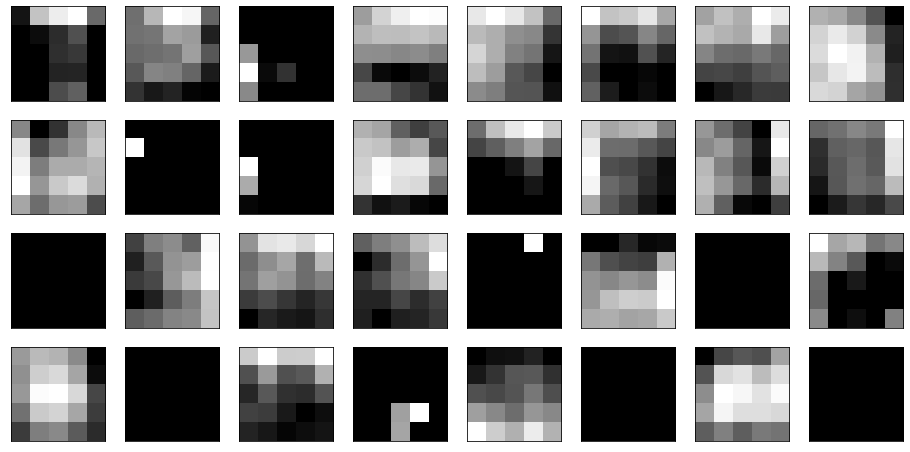

In [57]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input


from tensorflow.keras.preprocessing import image
import numpy as np
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import pylab
#model = VGG16(weights='imagenet', include_top=False)
#model = MobileNetV2(weights='imagenet', include_top=False)

if (is_local):
    img_path = './R_D_Images/BLB1.jpeg'
else:
    img_path = root_path + '/R_D_Images/BLB1.jpeg'
    

img = image.load_img(img_path)
Y = image.img_to_array(img)
Y = np.expand_dims(Y, axis=0)
Y = preprocess_input(Y)

features = conv_base.predict(Y)

print(features.shape)


row = 4
col = row * 2
ix = 1
pyplot.figure(figsize=(col * 2, row * 2))



for _ in range(row):
    for _ in range(col):
        # specify subplot and turn of axis
        ax = pyplot.subplot(row, col, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(features[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()



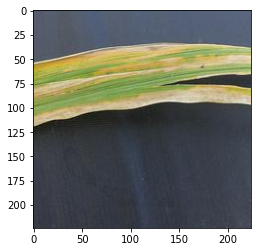

In [58]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(img)
plt.show()

(1, 5, 5, 2048)


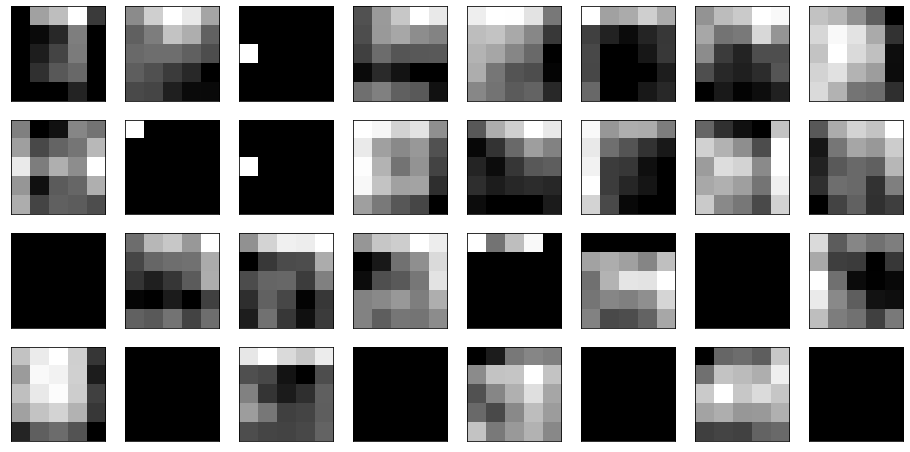

In [59]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input


from tensorflow.keras.preprocessing import image
import numpy as np
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import pylab
#model = VGG16(weights='imagenet', include_top=False)
#model = MobileNetV2(weights='imagenet', include_top=False)


if (is_local):
    img_path = './R_D_Images/BLB2.jpeg'
else:
    img_path = root_path + '/R_D_Images/BLB2.jpeg'
    
    
img = image.load_img(img_path)
Y = image.img_to_array(img)
Y = np.expand_dims(Y, axis=0)
Y = preprocess_input(Y)

features = conv_base.predict(Y)

print(features.shape)


row = 4
col = row * 2
ix = 1
pyplot.figure(figsize=(col * 2, row * 2))



for _ in range(row):
    for _ in range(col):
        # specify subplot and turn of axis
        ax = pyplot.subplot(row, col, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(features[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()



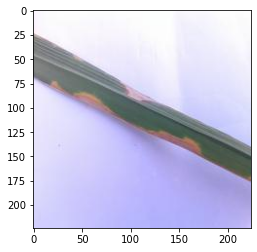

In [60]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(img)
plt.show()

In [63]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Feb 14 18:32:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.35       Driver Version: 471.35       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8    21W /  N/A |   7489MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------